In [1]:
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from sutils import *
import os, json
from os import walk
from glob import glob

from keras.applications import inception_v3
from keras.applications import vgg16
from keras.preprocessing import image 
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np
from keras.models import load_model
from keras_tqdm import TQDMNotebookCallback

from keras.applications.imagenet_utils import preprocess_input, decode_predictions

Using TensorFlow backend.


In [2]:
# create the base pre-trained model
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

In [3]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [4]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)



In [5]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_9
batch_normalization_9
activation_9
conv2d_7
conv2d_10
batch_normalization_7
batch_normalization_10
activation_7
activation_10
average_pooling2d_1
conv2d_6
conv2d_8
conv2d_11
conv2d_12
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
activation_6
activation_8
activation_11
activation_12
mixed0
conv2d_16
batch_normalization_16
activation_16
conv2d_14
conv2d_17
batch_normalization_14
batch_normalization_17
activation_14
activation_17
average_pooling2d_2
conv2d_13
conv2d_15
conv2d_18
conv2d_19
batch_normalization_13
batch_normalization_15
batch_normalization_18
batch_normalization_19
activation_13
activation_15
activation_18
activation_19
mixed1
conv2d_23
batch_normalization_23
activat

In [7]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
conv2d_1
False
batch_normalization_1
False
activation_1
False
conv2d_2
False
batch_normalization_2
False
activation_2
False
conv2d_3
False
batch_normalization_3
False
activation_3
False
max_pooling2d_1
False
conv2d_4
False
batch_normalization_4
False
activation_4
False
conv2d_5
False
batch_normalization_5
False
activation_5
False
max_pooling2d_2
False
conv2d_9
False
batch_normalization_9
False
activation_9
False
conv2d_7
False
conv2d_10
False
batch_normalization_7
False
batch_normalization_10
False
activation_7
False
activation_10
False
average_pooling2d_1
False
conv2d_6
False
conv2d_8
False
conv2d_11
False
conv2d_12
False
batch_normalization_6
False
batch_normalization_8
False
batch_normalization_11
False
batch_normalization_12
False
activation_6
False
activation_8
False
activation_11
False
activation_12
False
mixed0
False
conv2d_16
False
batch_normalization_16
False
activation_16
False
conv2d_14
False
conv2d_17
False
batch_normalization_14
False
batch_normalization_17
F

In [8]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
path = "data/"

In [10]:
batch_size=16
no_of_epochs=10

In [11]:
# Prepare images for training in batches
# NB: They must be in subdirectories named based on their category
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2)

Found 198 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [12]:
test = batches.next()

len(test[1][0])
test[1][12]

array([ 1.,  0.], dtype=float32)

In [13]:
hist = model.fit_generator(batches, steps_per_epoch=80, epochs=no_of_epochs,verbose=0,
                validation_data=val_batches, validation_steps=3,
                callbacks=[TQDMNotebookCallback(leave_inner=True,leave_outer=True)])

model.save('my_model1.h5')
del model
model = load_model('my_model1.h5')

In [14]:
metrics = model.evaluate_generator(val_batches,10,10,workers=1,pickle_safe=False)
print("model accuracy:",metrics[1])

/home/chenxukun/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras.pre..., 10, 10, workers=1, use_multiprocessing=False)`
  if __name__ == '__main__':


model accuracy: 1.0


In [15]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

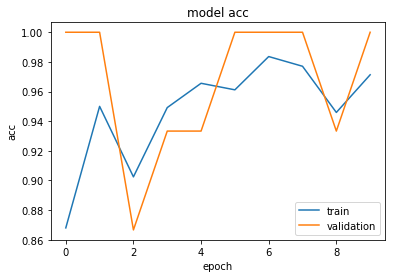

In [17]:
plot_train(hist)

In [2]:
model = load_model('my_model1.h5')

In [9]:
image_path = './data/test/'

In [4]:
def show_image(name):
    img_path = os.path.join(image_path, name)
    img=mpimg.imread(img_path)
    plt.imshow(img)

In [18]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

name = '10.jpg'

img_path = os.path.join(image_path, name)
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 299, 299, 3)


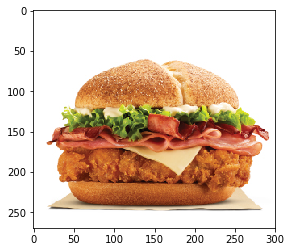

In [19]:
show_image(name)

In [20]:
preds = model.predict(x)
print('Predicted:', preds)

Predicted: [[ 0.87091255  0.12908742]]


In [21]:
result= np.argmax(preds)
if result==0:
    print("Its a burger")
else:
    print("Its a hotdog")

Its a burger
